<a href="https://colab.research.google.com/github/3venjd/Transfer_learning_vgg16_road_object/blob/main/Road_object_transfer_learning_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/Jimenez Evelio/17) Transfer Learning

/content/drive/My Drive/Colab Notebooks/Jimenez Evelio/17) Transfer Learning


In [ ]:
import numpy as np
from tensorflow import data
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
Image_Generator = ImageDataGenerator(rescale = 1./255, 
                                     rotation_range=45, 
                                     width_shift_range=.15, 
                                     height_shift_range=.15, 
                                     horizontal_flip=True, 
                                     zoom_range=0.5,
                                     validation_split = 0.2)

In [ ]:
base_dir = '/content/drive/My Drive/Colab Notebooks/Jimenez Evelio/14-15) Redes Neuronales Convolucionales/data_set_Actores Viales'

In [ ]:
train_data = Image_Generator.flow_from_directory(batch_size = 100,
                                                 directory = base_dir,
                                                 shuffle = True,
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 subset = 'training')

Found 8574 images belonging to 12 classes.


In [ ]:
val_data = Image_Generator.flow_from_directory(batch_size = 100,
                                               directory = base_dir,
                                               target_size = (224,224),
                                               class_mode = 'categorical',
                                               subset = 'validation')

Found 2137 images belonging to 12 classes.


In [ ]:
img = tf.keras.preprocessing.image.load_img(
    base_dir + '/bus/bus1.jpg', grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest"
)

In [ ]:
img.size

(256, 256)

In [ ]:
train_data.class_indices

{'Carriage': 0,
 'Cyclist': 1,
 'Pedestrians': 2,
 'Road Signs': 3,
 'bus': 4,
 'crosswalks': 5,
 'fireEgine': 6,
 'motorcycle': 7,
 'policecar': 8,
 'skateboard': 9,
 'taxi': 10,
 'traffic light': 11}

In [ ]:
val_data.labels

array([ 0,  0,  0, ..., 11, 11, 11], dtype=int32)

In [ ]:
IMG_SHAPE = 224

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions 

HEIGHT, WIDTH, CHANNELS = (IMG_SHAPE,IMG_SHAPE,3) # el tamaño con el que se entrenó VGG16
input_t = keras.Input(shape=(HEIGHT, WIDTH, CHANNELS))
VGG16_model = VGG16(weights='imagenet', include_top=True, input_tensor=input_t) # Se carga el modelo junto con los pesos preentrenados
VGG16_model.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

middle = VGG16_model.get_layer('block5_pool')
newmodel = Model(inputs = input_t, outputs=middle.output)
newmodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

middle = VGG16_model.get_layer('block5_pool')
newmodel = Model(inputs = input_t, outputs=middle.output)

#create model
model = Sequential()
#add model layers
model.add(newmodel)
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='softmax'))

for layer in model.layers[:-8]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 32)          147488    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               3

In [ ]:
batch_size = 100
epochs = 20
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.001), 
              loss = keras.losses.mean_squared_error, 
              metrics=['accuracy']
             )

In [ ]:
history = model.fit(
    train_data,
    steps_per_epoch=int(np.ceil(train_data.labels.shape[0] / float(batch_size))), 
    epochs=epochs,
    validation_data = val_data,
    validation_steps=int(np.ceil(val_data.labels.shape[0] / float(batch_size)))
)

Epoch 1/20
86/86 [==============================] - 178s 2s/step - loss: 0.0646 - accuracy: 0.3319 - val_loss: 0.0561 - val_accuracy: 0.4310
Epoch 2/20
86/86 [==============================] - 178s 2s/step - loss: 0.0501 - accuracy: 0.5245 - val_loss: 0.0469 - val_accuracy: 0.5508
Epoch 3/20
86/86 [==============================] - 176s 2s/step - loss: 0.0450 - accuracy: 0.5776 - val_loss: 0.0396 - val_accuracy: 0.6149
Epoch 4/20
86/86 [==============================] - 178s 2s/step - loss: 0.0427 - accuracy: 0.6019 - val_loss: 0.0379 - val_accuracy: 0.6392
Epoch 5/20
86/86 [==============================] - 175s 2s/step - loss: 0.0394 - accuracy: 0.6430 - val_loss: 0.0397 - val_accuracy: 0.6261
Epoch 6/20
86/86 [==============================] - 175s 2s/step - loss: 0.0392 - accuracy: 0.6407 - val_loss: 0.0424 - val_accuracy: 0.6055
Epoch 7/20
86/86 [==============================] - 178s 2s/step - loss: 0.0376 - accuracy: 0.6572 - val_loss: 0.0365 - val_accuracy: 0.6664
Epoch 8/20
86

Text(0.5, 1.0, 'Training and validation loss')

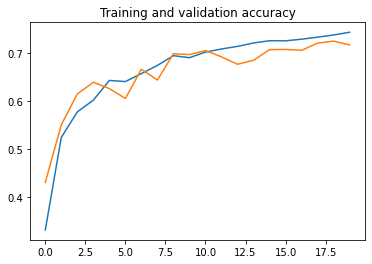

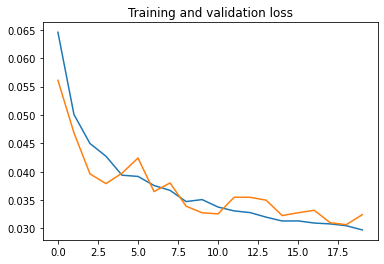

In [ ]:
import matplotlib.pyplot as plt

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc))


# Plot training and validation accuracy per epoch
plt.plot(epochs,acc)
plt.plot(epochs,val_acc)
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.title('Training and validation loss')

In [ ]:
model.save('transfer_learning_vgg16_road.h5') # Salvar la arquitectura para poder usarla fuera de esta implementación

In [ ]:
new_model = tf.keras.models.load_model('transfer_learning_vgg16_road.h5')
new_model.trainable = True
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 8, 8, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 512)         2359808   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 512)         2359808   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         2359808   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4

batch_size = 100
epochs = 100
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy']
             )


Epoch 1/100

    86/86 - 2604s 30s/step

    loss: 1.9078 - accuracy: 0.3472 - val_loss: 1.2493 -val_accuracy: 0.5063

Epoch 2/100
    
    86/86 222s 3s/step
    loss: 1.2236 - accuracy: 0.5589 - val_loss: 1.1461 - val_accuracy: 0.5887


Epoch 3/100

    86/86 220s 3s/step
    loss: 1.0678 - accuracy: 0.6401 - val_loss: 1.0145 - val_accuracy: 0.6462

Epoch 4/100

    86/86 221s 3s/step
    loss: 0.9587 - accuracy: 0.6817 - val_loss: 0.8971 - val_accuracy: 0.6982

Epoch 5/100


    86/86 223s 3s/step
    loss: 0.9101 - accuracy: 0.7019 - val_loss: 0.8735 - val_accuracy: 0.6982


Epoch 6/100

    86/86 223s 3s/step
    loss: 0.8609 - accuracy: 0.7200 - val_loss: 0.8156 - val_accuracy: 0.7230

Epoch 7/100

    86/86 223s 3s/step
    loss: 0.8105 - accuracy: 0.7405 - val_loss: 0.7967 - val_accuracy: 0.7291

Epoch 8/100

    86/86 221s 3s/step
    loss: 0.8068 - accuracy: 0.7391 - val_loss: 0.8623 - val_accuracy: 0.7103

Epoch 9/100

    86/86 222s 3s/step
    loss: 0.7567 - accuracy: 0.7537 - val_loss: 0.8569 - val_accuracy: 0.7117
    
Epoch 10/100


    86/86 222s 3s/step
    loss: 0.7511 - accuracy: 0.7540 - val_loss: 0.7452 - val_accuracy: 0.7496

Epoch 11/100

    86/86 221s 3s/step 
    loss: 0.7286 - accuracy: 0.7629 - val_loss: 0.8184 - val_accuracy: 0.7277

Epoch 12/100

    86/86 221s 3s/step 
    loss: 0.6961 - accuracy: 0.7658 - val_loss: 0.7619 - val_accuracy: 0.7454


Epoch 13/100

    86/86 221s 3s/step
    loss: 0.7100 - accuracy: 0.7697 - val_loss: 0.7751 - val_accuracy: 0.7548

Epoch 14/100

    86/86 220s 3s/step 
    loss: 0.6728 - accuracy: 0.7840 - val_loss: 0.7152 - val_accuracy: 0.7670

Epoch 15/100

    86/86 218s 3s/step
    loss: 0.6614 - accuracy: 0.7869 - val_loss: 0.7940 - val_accuracy: 0.7351

Epoch 16/100

    86/86 219s 3s/step
    loss: 0.6605 - accuracy: 0.7904 - val_loss: 0.7169 - val_accuracy: 0.7599

Epoch 17/100

    86/86 220s 3s/step
    loss: 0.6439 - accuracy: 0.7898 - val_loss: 0.7594 - val_accuracy: 0.7525

Epoch 18/100

    86/86 221s 3s/step
    loss: 0.6347 - accuracy: 0.7962 - val_loss: 0.7555 - val_accuracy: 0.7590

Epoch 19/100

    86/86 222s 3s/step
    loss: 0.6346 - accuracy: 0.7972 - val_loss: 0.6924 - val_accuracy: 0.7693

Epoch 20/100

    86/86 221s 3s/step
    loss: 0.6129 - accuracy: 0.8030 - val_loss: 0.7409 - val_accuracy: 0.7487

Epoch 21/100

    86/86 221s 3s/step
    loss: 0.6148 - accuracy: 0.8003 - val_loss: 0.7472 - val_accuracy: 0.7506

Epoch 22/100

    86/86 220s 3s/step
    loss: 0.6089 - accuracy: 0.8006 - val_loss: 0.7535 - val_accuracy: 0.7482

Epoch 23/100

    86/86 221s 3s/step
    loss: 0.6190 - accuracy: 0.7992 - val_loss: 0.6893 - val_accuracy: 0.7665

Epoch 24/100

    86/86 221s 3s/step
    loss: 0.5946 - accuracy: 0.8066 - val_loss: 0.6827 - val_accuracy: 0.7735

Epoch 25/100

    86/86 220s 3s/step
    loss: 0.5791 - accuracy: 0.8080 - val_loss: 0.6900 - val_accuracy: 0.7693

Epoch 26/100

    86/86 219s 3s/step 
    loss: 0.5715 - accuracy: 0.8135 - val_loss: 0.7107 - val_accuracy: 0.7777

Epoch 27/100

    86/86 218s 3s/step
    loss: 0.5796 - accuracy: 0.8149 - val_loss: 0.6540 - val_accuracy: 0.7857

Epoch 28/100

    86/86 219s 3s/step 
    loss: 0.5585 - accuracy: 0.8214 - val_loss: 0.7035 - val_accuracy: 0.7749

Epoch 29/100

    86/86 219s 3s/step 
    loss: 0.5629 - accuracy: 0.8176 - val_loss: 0.6828 - val_accuracy: 0.7726

Epoch 30/100

    86/86 219s 3s/step
    loss: 0.5718 - accuracy: 0.8116 - val_loss: 0.6257 - val_accuracy: 0.7857

Epoch 31/100

    86/86 219s 3s/step
    loss: 0.5507 - accuracy: 0.8168 - val_loss: 0.6094 - val_accuracy: 0.7978

Epoch 32/100

    86/86 218s 3s/step 
    loss: 0.5475 - accuracy: 0.8203 - val_loss: 0.6996 - val_accuracy: 0.7754

Epoch 33/100

    86/86 218s 3s/step 
    loss: 0.5594 - accuracy: 0.8181 - val_loss: 0.6899 - val_accuracy: 0.7735

Epoch 34/100

    86/86 218s 3s/step
    loss: 0.5252 - accuracy: 0.8343 - val_loss: 0.6758 - val_accuracy: 0.7759

Epoch 35/100

    86/86 221s 3s/step
    loss: 0.5527 - accuracy: 0.8163 - val_loss: 0.6711 - val_accuracy: 0.7936

Epoch 36/100

    86/86 219s 3s/step 
    loss: 0.5320 - accuracy: 0.8294 - val_loss: 0.6530 - val_accuracy: 0.7763

Epoch 37/100

    86/86 219s 3s/step
    loss: 0.5380 - accuracy: 0.8312 - val_loss: 0.6487 - val_accuracy: 0.7927

Epoch 38/100

    86/86 219s 3s/step 
    loss: 0.5176 - accuracy: 0.8316 - val_loss: 0.7627 - val_accuracy: 0.7585

Epoch 39/100

    86/86 217s 3s/step
    loss: 0.5376 - accuracy: 0.8287 - val_loss: 0.6738 - val_accuracy: 0.7838

Epoch 40/100

    86/86 218s 3s/step
    loss: 0.5200 - accuracy: 0.8289 - val_loss: 0.6747 - val_accuracy: 0.7810

Epoch 41/100

    86/86 218s 3s/step
    loss: 0.5299 - accuracy: 0.8293 - val_loss: 0.6942 - val_accuracy: 0.7861

Epoch 42/100

    86/86 218s 3s/step
    loss: 0.5206 - accuracy: 0.8312 - val_loss: 0.6950 - val_accuracy: 0.7777

Epoch 43/100

    86/86 219s 3s/step 
    loss: 0.5124 - accuracy: 0.8357 - val_loss: 0.6637 - val_accuracy: 0.7712

Epoch 44/100

    86/86 219s 3s/step
    loss: 0.4979 - accuracy: 0.8386 - val_loss: 0.7022 - val_accuracy: 0.7693

Epoch 45/100

    86/86 218s 3s/step
    loss: 0.5225 - accuracy: 0.8307 - val_loss: 0.7160 - val_accuracy: 0.7646

Epoch 46/100

    86/86 219s 3s/step
    loss: 0.5347 - accuracy: 0.8293 - val_loss: 0.7305 - val_accuracy: 0.7665

Epoch 47/100

    86/86 217s 3s/step
    loss: 0.5049 - accuracy: 0.8360 - val_loss: 0.6272 - val_accuracy: 0.7899

Epoch 48/100

    86/86 217s 3s/step
    loss: 0.5090 - accuracy: 0.8350 - val_loss: 0.6528 - val_accuracy: 0.7866

Epoch 49/100

    86/86 217s 3s/step
    loss: 0.4988 - accuracy: 0.8411 - val_loss: 0.7675 - val_accuracy: 0.7623

Epoch 50/100

    86/86 221s 3s/step 
    loss: 0.4810 - accuracy: 0.8403 - val_loss: 0.7840 - val_accuracy: 0.7506

Epoch 51/100

    86/86 219s 3s/step
    loss: 0.4761 - accuracy: 0.8456 - val_loss: 0.7442 - val_accuracy: 0.7707

Epoch 52/100

    86/86 217s 3s/step
    loss: 0.4859 - accuracy: 0.8415 - val_loss: 0.6849 - val_accuracy: 0.7773

Epoch 53/100

    86/86 217s 3s/step 
    loss: 0.4857 - accuracy: 0.8417 - val_loss: 0.6423 - val_accuracy: 0.7857

Epoch 54/100

    86/86 217s 3s/step
    loss: 0.4744 - accuracy: 0.8459 - val_loss: 0.7539 - val_accuracy: 0.7684

Epoch 55/100

    86/86 220s 3s/step
    loss: 0.4892 - accuracy: 0.8371 - val_loss: 0.6543 - val_accuracy: 0.7885

Epoch 56/100

    86/86 219s 3s/step
    loss: 0.4838 - accuracy: 0.8445 - val_loss: 0.6623 - val_accuracy: 0.7922

Epoch 57/100

    86/86 221s 3s/step
    loss: 0.4801 - accuracy: 0.8429 - val_loss: 0.7131 - val_accuracy: 0.7721

Epoch 58/100

    86/86220s 3s/step
    loss: 0.4752 - accuracy: 0.8441 - val_loss: 0.6724 - val_accuracy: 0.7927

Epoch 59/100

    86/86 220s 3s/step
    loss: 0.4781 - accuracy: 0.8418 - val_loss: 0.7634 - val_accuracy: 0.7590

Epoch 60/100

    86/86 219s 3s/step
    loss: 0.4680 - accuracy: 0.8423 - val_loss: 0.6911 - val_accuracy: 0.7894

Epoch 61/100

    86/86 217s 3s/step
    loss: 0.4668 - accuracy: 0.8472 - val_loss: 0.7146 - val_accuracy: 0.7805

Epoch 62/100

    86/86 218s 3s/step
    loss: 0.4654 - accuracy: 0.8472 - val_loss: 0.7101 - val_accuracy: 0.7745

Epoch 63/100

    86/86 219s 3s/step
    loss: 0.4698 - accuracy: 0.8420 - val_loss: 0.7049 - val_accuracy: 0.7810

Epoch 64/100

    86/86 221s 3s/step
    loss: 0.4499 - accuracy: 0.8526 - val_loss: 0.6607 - val_accuracy: 0.7927

Epoch 65/100

    86/86 222s 3s/step 
    loss: 0.4662 - accuracy: 0.8453 - val_loss: 0.7241 - val_accuracy: 0.7843

Epoch 66/100

    86/86 222s 3s/step
    loss: 0.4394 - accuracy: 0.8574 - val_loss: 0.6386 - val_accuracy: 0.8011

Epoch 67/100

    86/86 220s 3s/step
    loss: 0.4562 - accuracy: 0.8493 - val_loss: 0.7216 - val_accuracy: 0.7754

Epoch 68/100

    86/86 221s 3s/step
    loss: 0.4514 - accuracy: 0.8575 - val_loss: 0.6576 - val_accuracy: 0.7847

Epoch 69/100

    86/86 221s 3s/step
    loss: 0.4591 - accuracy: 0.8504 - val_loss: 0.6627 - val_accuracy: 0.7880

Epoch 70/100

    86/86 220s 3s/step
    loss: 0.4513 - accuracy: 0.8569 - val_loss: 0.7096 - val_accuracy: 0.7791

Epoch 71/100

    86/86 221s 3s/step
    loss: 0.4628 - accuracy: 0.8523 - val_loss: 0.6746 - val_accuracy: 0.7876

Epoch 72/100

    86/86 222s 3s/step
    loss: 0.4532 - accuracy: 0.8511 - val_loss: 0.6520 - val_accuracy: 0.7974

Epoch 73/100

    86/86 222s 3s/step
    loss: 0.4647 - accuracy: 0.8537 - val_loss: 0.6996 - val_accuracy: 0.7871

Epoch 74/100

    86/86 221s 3s/step
    loss: 0.4530 - accuracy: 0.8509 - val_loss: 0.7288 - val_accuracy: 0.7801

Epoch 75/100

    86/86 221s 3s/step
    loss: 0.4632 - accuracy: 0.8516 - val_loss: 0.6911 - val_accuracy: 0.7815

Epoch 76/100

    86/86 222s 3s/step
    loss: 0.4537 - accuracy: 0.8529 - val_loss: 0.7241 - val_accuracy: 0.7861

Epoch 77/100

    86/86 222s 3s/step
    loss: 0.4522 - accuracy: 0.8550 - val_loss: 0.6206 - val_accuracy: 0.8039

Epoch 78/100

    86/86 221s 3s/step
    loss: 0.4211 - accuracy: 0.8581 - val_loss: 0.6933 - val_accuracy: 0.7861

Epoch 79/100

    86/86 222s 3s/step
    loss: 0.4561 - accuracy: 0.8505 - val_loss: 0.6756 - val_accuracy: 0.7913

Epoch 80/100

    86/86 222s 3s/step
    loss: 0.4385 - accuracy: 0.8572 - val_loss: 0.6367 - val_accuracy: 0.7805

Epoch 81/100

    86/86 220s 3s/step
    loss: 0.4532 - accuracy: 0.8523 - val_loss: 0.6638 - val_accuracy: 0.7880

Epoch 82/100
    
    86/86 221s 3s/step
    loss: 0.4234 - accuracy: 0.8600 - val_loss: 0.7161 - val_accuracy: 0.7759

Epoch 83/100

    86/86 223s 3s/step
    loss: 0.4209 - accuracy: 0.8635 - val_loss: 0.6702 - val_accuracy: 0.7988

Epoch 84/100

    86/86 223s 3s/step
    loss: 0.4319 - accuracy: 0.8606 - val_loss: 0.7057 - val_accuracy: 0.7880

Epoch 85/100

    86/86 222s 3s/step
    loss: 0.4299 - accuracy: 0.8634 - val_loss: 0.6718 - val_accuracy: 0.7857

Epoch 86/100

    86/86 223s 3s/step
    loss: 0.4469 - accuracy: 0.8548 - val_loss: 0.7501 - val_accuracy: 0.7670

Epoch 87/100

    86/86 219s 3s/step
    loss: 0.4400 - accuracy: 0.8530 - val_loss: 0.6762 - val_accuracy: 0.7843

Epoch 88/100

    86/86 219s 3s/step
    loss: 0.4153 - accuracy: 0.8641 - val_loss: 0.6579 - val_accuracy: 0.7927

Epoch 89/100

    86/86 219s 3s/step
    loss: 0.4222 - accuracy: 0.8633 - val_loss: 0.6184 - val_accuracy: 0.8053

Epoch 90/100

    86/86 219s 3s/step
    loss: 0.4336 - accuracy: 0.8579 - val_loss: 0.6281 - val_accuracy: 0.8021

Epoch 91/100

    86/86 221s 3s/step
    loss: 0.4142 - accuracy: 0.8669 - val_loss: 0.6897 - val_accuracy: 0.7946

Epoch 92/100

    86/86 221s 3s/step
    loss: 0.4163 - accuracy: 0.8700 - val_loss: 0.7343 - val_accuracy: 0.7866

Epoch 93/100

    86/86 220s 3s/step
    loss: 0.4218 - accuracy: 0.8592 - val_loss: 0.7181 - val_accuracy: 0.7876

Epoch 94/100

    86/86 219s 3s/step
    loss: 0.4258 - accuracy: 0.8635 - val_loss: 0.6587 - val_accuracy: 0.8114

Epoch 95/100

    86/86 219s 3s/step
    loss: 0.4192 - accuracy: 0.8641 - val_loss: 0.6452 - val_accuracy: 0.8067

Epoch 96/100

    86/86 220s 3s/step
    loss: 0.4428 - accuracy: 0.8544 - val_loss: 0.6826 - val_accuracy: 0.7913

Epoch 97/100

    86/86 222s 3s/step
    loss: 0.4036 - accuracy: 0.8691 - val_loss: 0.6777 - val_accuracy: 0.7876

Epoch 98/100

    86/86 221s 3s/step
    loss: 0.4239 - accuracy: 0.8618 - val_loss: 0.7513 - val_accuracy: 0.7735

Epoch 99/100

    86/86 219s 3s/step
    loss: 0.4159 - accuracy: 0.8676 - val_loss: 0.6255 - val_accuracy: 0.7997

Epoch 100/100

    86/86 220s 3s/step
    loss: 0.4329 - accuracy: 0.8574 - val_loss: 0.6615 - val_accuracy: 0.8007

    